# Datasets & DataLoaders
Code for processing data sampeles can get messy and hard maintain; 
we ideally want our dataset code to be decoupled from our model training code for better readability and modularity.
PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utlis.data.Dataset` that allow tou to use pre-loaded datasets as well as your own data.
`Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass `torch.utils.data.Dataset` and implement functions specific to the particular data.
They can be used to prototype and benchmarck your model.
You can find them here: [Image Datasets](https://pytorch.org/vision/stable/datasets.html), [Text Datasets](https://pytorch.org/text/stable/datasets.html), and [Audio Datasets](https://pytorch.org/audio/stable/datasets.html).

データサンプルを処理するためのコードは乱雑で維持が難しくなり可能性がある；
理想的には可読性とモジュール性を良くする為に，データセットのコードとモデルトレーニングのコードを分断させたい．
PyTorchは，二つのプリミティブ型がある：`torch.utils.data.DataLoader`と`torch.utils.data.Dataset`であり，これらは自分のデータと同様に事前にロードされたデータを使うことができる．
`Dataset`はラベルと対応したサンプルが保存され，`DataLoader`はサンプルにアクセスしやすくする為に`Dataset`周りのイテラブルをラップしている．

PyTorchのドメインライブラリは，`torch.utils.data.Dataset`のサブクラスでFasionMNISTのような事前にロードされたデータセットをいくつか提供し，特定のデータに固有の関数を実装している．
自分のモデルのプロトタイプやベンチマークとして使用できる．
詳しくはURLを見る．

## Loading a Dataset
Here is an example of how to load the Fashion-MNIST dataset from TorchVision. 
Fashion-MNIST is a dataset of Zalando's article images consisting of 60,000 training examples and 10,000 test examples.
Each example comprises a 28x28 grayscale image and associated label from one of 10 calsses.

We load the Fashion MNIST Dataset with the following parameters.

- `root` is the path where the train/test data is stored,
- `train` specifies training or test dataset,
- `download=True` downloads the data from the internet if it's not abailable at `root`.
- `transform` and `target_transform` specify the feature and label transformations.

ここではTorchVisionのFashion-MNISTデータセットのロードの仕方を例に説明する．
Fasion-MNISTは60,000枚のトレーニング画像と10,000枚のテスト画像からなるZalando社の画像である．
それぞれの画像は28x28のグレースケールで，ラベルは10クラスからなる．

以下のパラメータを指定して，FashionMNISTデータセットをロードする．

- `root`は訓練/テストデータが保存されているパスである
- `train`は訓練かテストかを指定する
- `download=True`は`root`が利用できなければインターネットからダウンロードする
- `transform`と`target_transform`は特徴量とラベルを変換方法を指定する

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
print(f'torch ver. {torch.__version__}')

torch ver. 1.8.1


In [4]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

## Iterating and Visualizing the Dataset
We can index `Datasets` manually like at a list: `training_data[index]`.
We use `matplotlib` to visualize some samples in our training data.

リストのように手動で`Datasets`をインデックス指定できる．
`matplotlib`を使ってトレーニングデータの画像を可視化できる．

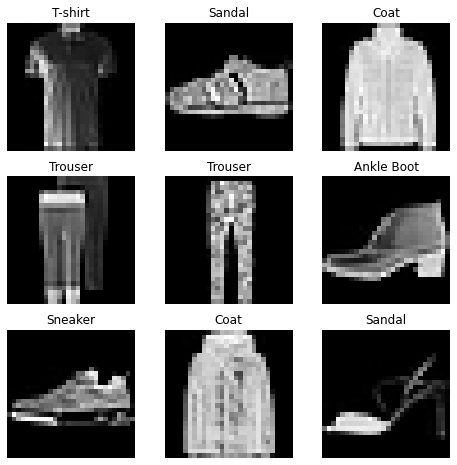

In [8]:
labels_map = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1, )).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

## Creating a Custom Dataset for your files
A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`.
Take a look at this implementation; the FashionMNIST images are stored in a directory `img_dir`, and their labels are stored separately in a CSV file `annotation_file`.

In the next section, we'll break down waht's happening in each of these functions.

カスタムデータセットに三つの関数を実装する: `__init__`, `__len__`, and `__getitem__`．
以下の実装を見る；
FashionMINIST画像は`img_dir`ディレクトリに保存されていて，ラベルは`annotation_file`csvファイルに保存されている．

次のセクションでは，それぞれの関数で何が起きているかを分析する．

In [9]:
import os
import pandas as pd
from torchvision.io import read_image

class CutomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_lebels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transfomr:
            label = self.target_transform(label)
        sample = {'image': image, 'label': label}
        return sample

### __init__
The `__init__` function is run once when instantiating the Dataset object.
We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).

The labels.csv file looks like:

`__init__`関数はデータセットオブジェクトがインスタンス化された時に一度だけ実行される．
画像が保存されたディレクトリやアノテーションファイル，変換をを初期化する．
csvファイルは以下のようになっている

```{python}
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankeboot999.jpg, 9
```

In [12]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### __len__
The `__len__` function returns the number of samples in our dataset.

`__len__`関数はデータセットのサンプルの数を返す

In [13]:
def __len__(self):
    return len(self.img_labels)

### __getitem__
The `__getitem__` function loads and returns a sample from the dataset at the given index `idx`.
Based on the index, it identifies the image's location on disk, converts that to a tensor using `read_image`, retrieves the corresponding label from the csv data in `self.img_labels`,
calls the transform function on them (if applicable), and returns the tensor image and corresponding label in a Python dict.

`__getitem__`関数は与えられた`idx`のデータセットのサンプルをロードし返す．
インデックスに基づき，ディスク上の画像位置を特定し，`read_image`を用いてtensorへと変換し，`self.img_labels`の csvデータから一致するラベルを取得し，該当する場合，それらの利用関数を呼び出し，
Pythonディクショナリーでtensor画像と一致するラベルを返す．

In [14]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transfomr:
        label = self.target_transform(label)
    sample = {'image': image, 'label': label}
    return sample

## Preparing your data for training with DataLoaders
The `Dataset` retrieves our dataset's features and labels on samples at a time.
While training a model, we typically want to pass sampless in 'minibatches', reshuffle the data at every epoch to reduce model overfitting, and use Python's `multiprocessing` to speed up data retrival.

`DataLoader` is an iterable that abstracts this complecity for us in an easy API.

`Dataset`はサンプルデータセットの同時に特徴量とラベルを取得する．
モデルのトレーニング中は，一般的にミニバッチの中にサンプルを渡し，モデルの過剰適合を減らす為にエポックごとにシャッフルし，Pythonの`multiprocessing`を使ってデータの取得を高速化する．

`DataLoader`は簡単なAPIでこの完全性を抽象化する反復可能なオブジェクトである

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader
We have loaded that dataset into the `Dataloader` and can iterate through the dataset as needed.
Each iteration below returns a batch of `train_features` and `train_labels` (containing `batch_size=64` features and labels respectively).
Because we specified `shuffle=True`, after we iterate over all batches the data is shuffled (for finer-grainde control over the data loading order, takle a look at [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler))

`Dataloader`にデータセットをロードし，必要に応じてデータセットを反復処理できる．
以下の各反復は，`train_features`と`traon_labels`のバッチを返す(それぞれ，64の特徴量とラベルを含む)．
`shuffle=True`を指定したため，全てのバッチを反復処理した後に，データがシャッフルされる(データの読み込み順序をより細かく-荒く制御する為にはURLを見る)．

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


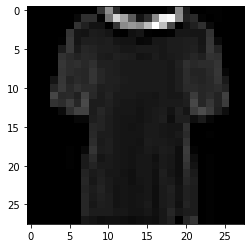

Lable: 6


In [18]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_feature.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Lable: {label}')